In [1]:
import pandas as pd

In [2]:
%pwd

'/home/panayot/Documents/site_similarity/notebooks/node_features_graphs/corpus 2020'

In [3]:
node_features_file = "../../generate_node_features/corpus_2020_audience_overlap_level_0_and_1_node_features.csv"
edge_file = "../../generate_node_features/combined_data_corpus_2020_level_0_1_df_edges.csv"

In [4]:
node_features_df = pd.read_csv(node_features_file, index_col=0)

In [5]:
node_features_df.head()

,alexa_ranks,daily_pageviews_per_visitors,daily_time_on_sites,total_sites_linking_ins,bounce_rate
gradescope.com,11014.0,4.7,296.0,103.0,0.222
parentlink.net,151438.0,3.0,203.0,93.0,0.301
nationalpartnership.org,604522.0,1.3,156.0,811.0,0.765
sharondraper.com,1209734.0,2.0,109.0,209.0,0.615
trade.gov,55944.0,1.9,137.0,2392.0,0.654


In [6]:
node_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12303 entries, gradescope.com to growveg.com
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alexa_ranks                   9128 non-null   float64
 1   daily_pageviews_per_visitors  9129 non-null   float64
 2   daily_time_on_sites           6780 non-null   float64
 3   total_sites_linking_ins       11966 non-null  float64
 4   bounce_rate                   6300 non-null   float64
dtypes: float64(5)
memory usage: 576.7+ KB


In [7]:
node_features_df.alexa_ranks = node_features_df.alexa_ranks.fillna(0)
node_features_df.total_sites_linking_ins = node_features_df.total_sites_linking_ins.fillna(0)

In [8]:
node_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12303 entries, gradescope.com to growveg.com
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alexa_ranks                   12303 non-null  float64
 1   daily_pageviews_per_visitors  9129 non-null   float64
 2   daily_time_on_sites           6780 non-null   float64
 3   total_sites_linking_ins       12303 non-null  float64
 4   bounce_rate                   6300 non-null   float64
dtypes: float64(5)
memory usage: 576.7+ KB


# Normalizing features

In [9]:
node_features_df['normalized_alexa_rank'] = node_features_df['alexa_ranks'].apply(lambda x: 1/x if x else 0)

In [10]:
import math

node_features_df['normalized_total_sites_linked_in'] = node_features_df['total_sites_linking_ins'].apply(lambda x: math.log2(x) if x else 0)

---

In [11]:
edge_df = pd.read_csv(edge_file)

edge_df.head()

,source,target
0,crooked.com,votesaveamerica.com
1,crooked.com,art19.com
2,crooked.com,promocodeportal.com
3,crooked.com,mediamatters.org
4,crooked.com,actblue.com


In [12]:
edge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28381 entries, 0 to 28380
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  28381 non-null  object
 1   target  28381 non-null  object
dtypes: object(2)
memory usage: 443.6+ KB


In [13]:
import stellargraph as sg

In [14]:
G = sg.StellarGraph(node_features_df[['normalized_alexa_rank', 'normalized_total_sites_linked_in']], edge_df)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 12303, Edges: 28381

 Node types:
  default: [12303]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [28381]
        Weights: all 1 (default)
        Features: none


# Unsupervised Deep Graph Infomax

In [15]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from tensorflow import keras

1. Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk, and random seed.

In [16]:
nodes = list(G.nodes())
number_of_walks = 1
length = 5

2. Create the UnsupervisedSampler instance with the relevant parameters passed to it.

In [17]:
fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)
gcn_model = GCN(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

Using GCN (local pooling) filters...


In [18]:
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

3. Create a node pair generator:

In [19]:
infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

deep_graph_infomax_model = Model(inputs=x_in, outputs=x_out)
deep_graph_infomax_model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

In [20]:
from stellargraph.utils import plot_history

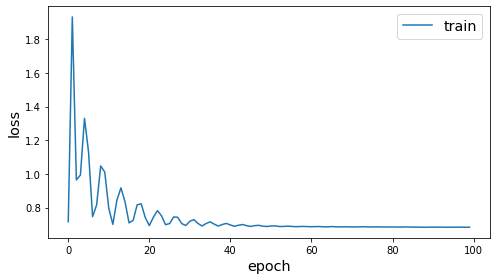

In [21]:
epochs = 100

es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = deep_graph_infomax_model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
plot_history(history)

In [22]:
x_emb_in, x_emb_out = gcn_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
x_out = tf.squeeze(x_emb_out, axis=0)
emb_model = Model(inputs=x_emb_in, outputs=x_out)

In [23]:
node_features_fullbactch_generator = fullbatch_generator.flow(node_features_df.index)
node_embeddings = emb_model.predict(node_features_fullbactch_generator)

In [24]:
embeddings_wv = dict(zip(node_features_df.index.tolist(), node_embeddings))

In [25]:
embeddings_wv['crooked.com']

array([0.643434  , 0.        , 0.        , 0.40236887, 0.        ,
       0.        , 0.        , 0.        , 0.01704657, 0.        ,
       0.        , 0.        , 0.        , 1.3440589 , 0.5210111 ,
       0.08131551, 0.        , 0.        , 0.93831795, 0.        ,
       0.        , 0.        , 1.2400693 , 0.78283113, 0.93368524,
       0.        , 0.6353502 , 0.61186576, 0.771381  , 0.8717407 ,
       0.        , 0.8352857 , 0.7260768 , 0.        , 1.2312161 ,
       0.8145563 , 1.097587  , 0.        , 0.        , 0.37798414,
       1.1464567 , 0.        , 0.6374953 , 0.        , 0.15308574,
       1.0010518 , 0.88731915, 0.7035137 , 0.        , 0.8316048 ,
       0.30785745, 0.        , 0.01222351, 1.075107  , 0.        ,
       1.2463897 , 0.        , 0.        , 1.1128811 , 0.7451658 ,
       1.3513131 , 0.17386816, 0.88290596, 0.37828985, 0.4278197 ,
       0.        , 1.0422156 , 0.        , 0.        , 1.1161499 ,
       0.69170934, 0.02125408, 0.2905244 , 0.56886536, 0.     

In [26]:
class ModelWrapper:
    def __init__(self, embeddings_wv):
        self.wv = embeddings_wv
        
    def __str__(self):
        return 'Unsupervised Deep Graph Infomax'

In [27]:
import sys,os
sys.path.append("/home/panayot/Documents/site_similarity")

In [28]:
from utils.notebook_utils import train_model

In [29]:
data_year = '2020'
node2vec_model = ModelWrapper(embeddings_wv)

In [34]:
%pwd

C:\Users\Paco\Documents\site_similarity\notebooks\node_features_graphs


In [35]:
%run ../../utils/notebook_utils.py

In [30]:
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV

In [33]:
result_report = []

clf = LogisticRegressionCV(Cs=10, cv=5, scoring="accuracy", multi_class="ovr", max_iter=300, random_state=42)
result_report.append([
    str(node2vec_model),
    'LogisticRegression CV = 5',
    *list(train_model(clf, node2vec_model=node2vec_model, data_year=data_year).values())
]);

clf2 = LogisticRegressionCV(Cs=10, cv=10, scoring="accuracy", multi_class="ovr", max_iter=300, random_state=42)
result_report.append([
    str(node2vec_model),
    'LogisticRegression CV = 10',
    *list(train_model(clf2, node2vec_model=node2vec_model, data_year=data_year).values())
]);

tree_clf = GradientBoostingClassifier(random_state=42)
result_report.append([
    str(node2vec_model),
    'GradientBoostingClassifier',
    *list(train_model(tree_clf, node2vec_model=node2vec_model, data_year=data_year).values())
]);

svm_clf = svm.SVC(decision_function_shape='ovo', probability=True, random_state=42)
result_report.append([
    str(node2vec_model),
    'SVC ovo',
    *list(train_model(svm_clf, node2vec_model=node2vec_model, data_year=data_year).values())
]);

model_res = pd.DataFrame(result_report,
                    columns=["Feature", "Classifier", "Accuracy", "Balanced Accuracy score",
                             "F1 micro score", "F1 macro score", "F1 weighted score", "MAE", "Confusion matrix"])

Start training...
Start training...
Start training...
Start training...


In [32]:
model_res.head()

,Feature,Classifier,Accuracy,Balanced Accuracy score,F1 micro score,F1 macro score,F1 weighted score,MAE,Confusion matrix
0,Unsupervised Deep Graph Infomax,LogisticRegression CV = 5,0.543655,0.368041,0.543655,0.312668,0.431847,0.612340,"[[8, 26, 128], [17, 21, 207], [6, 8, 438]]"
1,Unsupervised Deep Graph Infomax,LogisticRegression CV = 10,0.550640,0.375433,0.550640,0.324154,0.443519,0.603027,"[[6, 31, 125], [8, 30, 207], [7, 8, 437]]"
2,Unsupervised Deep Graph Infomax,GradientBoostingClassifier,0.532014,0.429081,0.532014,0.428336,0.502982,0.601863,"[[40, 41, 81], [35, 63, 147], [34, 64, 354]]"
3,Unsupervised Deep Graph Infomax,SVC ovo,0.544820,0.378853,0.544820,0.331557,0.453935,0.585565,"[[1, 52, 109], [2, 52, 191], [3, 34, 415]]"
